In [1]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.8.10
pandas==1.5.1
numpy==1.23.4
sklearn==1.1.3
torch==1.13.0+cu117
matplotlib==3.6.2


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
#load data
data = pd.read_csv("..\..\Data\Day\S&P 500 Historical Data00-20.csv")

In [5]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [6]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
4999,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
4998,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
4997,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
4996,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4995,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [7]:
data.index = data.index[::-1]

In [8]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [9]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [10]:
special_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
1,2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2,2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
3,2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
4,2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%


In [11]:
#change indexes
special_data.set_index('Date', inplace=True)

In [12]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

In [13]:
special_data.head()

,Price
Date,
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69
2010-01-08,1144.98


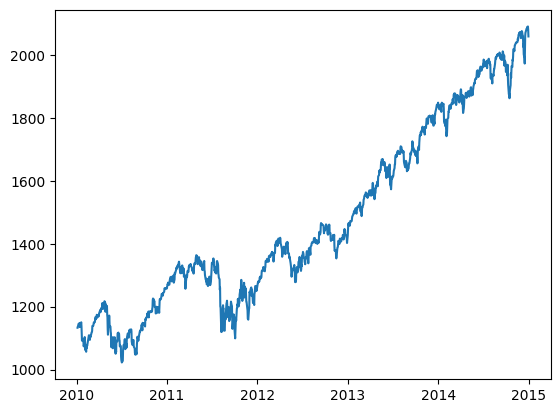

In [14]:
plt.plot(special_data)

In [48]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(special_data)

seq_length = 100
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.7)
val_size = 100
test_size = len(y) - train_size - val_size

dataX = Variable(torch.Tensor(np.array(x)).to(device))
dataY = Variable(torch.Tensor(np.array(y)).to(device))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

testX = Variable(torch.Tensor(np.array(x[train_size:(len(x) - val_size)])).to(device))
testY = Variable(torch.Tensor(np.array(y[train_size:(len(y) - val_size)])).to(device))

valX = Variable(torch.Tensor(np.array(x[(len(x) - val_size):len(x)])).to(device))
valY = Variable(torch.Tensor(np.array(y[(len(x) - val_size):len(y)])).to(device))


In [50]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(trainX, trainY)
test_dataset = TimeSeriesDataset(testX, testY)
val_dataset = TimeSeriesDataset(valX, valY)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [51]:
class RNNForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNForecast, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])

        return out

Epoch [1/300], Train Loss: 0.1400, Valid Loss: 0.5673
Epoch [11/300], Train Loss: 0.0258, Valid Loss: 0.0886
Epoch [21/300], Train Loss: 0.0155, Valid Loss: 0.1718
Epoch [31/300], Train Loss: 0.0131, Valid Loss: 0.1313
Epoch [41/300], Train Loss: 0.0102, Valid Loss: 0.0768
Epoch [51/300], Train Loss: 0.0056, Valid Loss: 0.0528
Epoch [61/300], Train Loss: 0.0008, Valid Loss: 0.0005
Epoch [71/300], Train Loss: 0.0006, Valid Loss: 0.0052
Epoch [81/300], Train Loss: 0.0004, Valid Loss: 0.0021
Epoch [91/300], Train Loss: 0.0004, Valid Loss: 0.0010
Epoch [101/300], Train Loss: 0.0004, Valid Loss: 0.0026
Epoch [111/300], Train Loss: 0.0004, Valid Loss: 0.0011
Epoch [121/300], Train Loss: 0.0003, Valid Loss: 0.0016
Epoch [131/300], Train Loss: 0.0003, Valid Loss: 0.0014
Epoch [141/300], Train Loss: 0.0003, Valid Loss: 0.0013
Epoch [151/300], Train Loss: 0.0003, Valid Loss: 0.0013
Epoch [161/300], Train Loss: 0.0003, Valid Loss: 0.0012
Epoch [171/300], Train Loss: 0.0003, Valid Loss: 0.0012
Epo

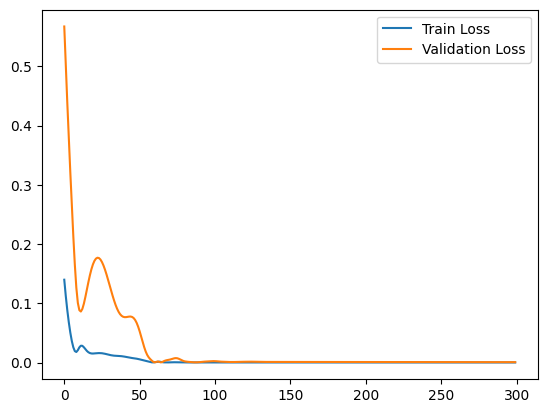

In [52]:
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1

model = RNNForecast(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train_loss = []
valid_loss = []
num_epochs = 300

for epoch in range(num_epochs):
    # set the model to train mode
    model.train()

    # forward pass
    output = model(trainX)
    loss = criterion(output, trainY)

    # backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate training loss
    train_loss.append(loss.item())

    # set the model to evaluation mode
    model.eval()

    # calculate validation loss
    with torch.no_grad():
        output = model(testX)
        loss = criterion(output, testY)
        valid_loss.append(loss.item())

    # print progress
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(
            epoch+1, num_epochs, train_loss[-1], valid_loss[-1]))

# plot train and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error
# Test the model
model.eval()
test_predict = model(testX)

test_predict_inv = sc.inverse_transform(test_predict.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())

test_score = np.sqrt(mean_squared_error(testY_inv, test_predict_inv))
print("Test RMSE Score: %.2f" % test_score)

Test RMSE Score: 31.08


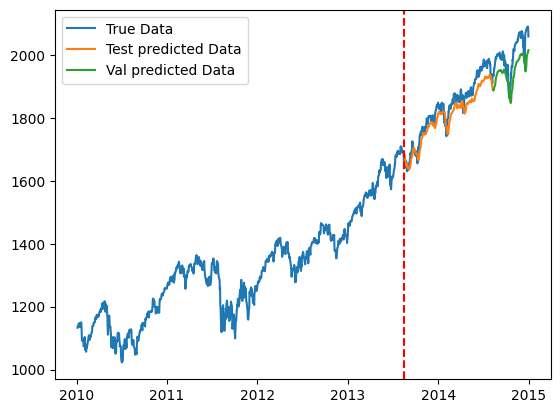

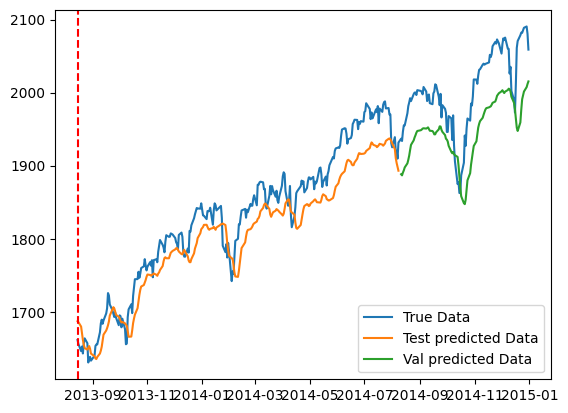

In [55]:
import matplotlib.pyplot as plt

# make predictions
predY_test = model(testX)
predY_val = model(valX)

# invert scaling for forecast
predY_test_inv = sc.inverse_transform(predY_test.cpu().detach().numpy())
predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())
# plot 1
plt.plot(special_data, label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=special_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()
# plot 2
plt.plot(special_data.index[-len(predY_test_inv)- val_size:], special_data.Price[-len(predY_test_inv)- val_size:], label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=special_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()

## Инициализация

In [2]:
%matplotlib inline
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
class RNNForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNForecast, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])

        return out


## Чтение входных данных

### Загрузка данных

In [47]:
data = pd.read_csv("..\..\Data\Day\\dje_Linear.csv", index_col = 0)

### Трансформация данных

In [48]:
def data_transformer(data):
    if 'Close' in data.columns:
        data = data.replace(",", "", regex=True)
        data.Date = pd.to_datetime(data.Date)
        data = data.sort_values(by=["Date"])
        data.set_index('Date')
        data.Close = data.Close.astype(float)
        data.High = data.High.astype(float)
        data.Low = data.Low.astype(float)
        data.Open = data.Open.astype(float)
        data["Vol"] = data["Vol"].astype(float)
    else:
        data = data.replace(",", "", regex = True)
        data.Date = pd.to_datetime(data.Date)
        data = data.sort_values(by=["Date"])
        data.set_index('Date')
        data.Price = data.Price.astype(float)
        data.High = data.High.astype(float)
        data.Low = data.Low.astype(float)
        data.Open = data.Open.astype(float)
        data["Vol."] = data["Vol."].astype(float)

In [49]:
data_transformer(data)

In [50]:
data.head()

,Date,Open,High,Low,Close,Vol
0,2010-01-04,10580.78,10583.13,10580.78,10583.13,0.0
1,2010-01-05,10568.24,10568.92,10567.41,10568.92,0.0
2,2010-01-06,10571.87,10573.00,10571.79,10572.47,0.0
3,2010-01-07,10605.12,10608.07,10605.12,10608.07,0.0
4,2010-01-08,10612.00,10614.19,10611.92,10614.19,0.0


In [51]:
data.index = data.index[::-1]

In [52]:
data.head()

,Date,Open,High,Low,Close,Vol
1457,2010-01-04,10580.78,10583.13,10580.78,10583.13,0.0
1456,2010-01-05,10568.24,10568.92,10567.41,10568.92,0.0
1455,2010-01-06,10571.87,10573.00,10571.79,10572.47,0.0
1454,2010-01-07,10605.12,10608.07,10605.12,10608.07,0.0
1453,2010-01-08,10612.00,10614.19,10611.92,10614.19,0.0


In [53]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [54]:
special_data.head()

,Date,Open,High,Low,Close,Vol
1457,2010-01-04,10580.78,10583.13,10580.78,10583.13,0.0
1456,2010-01-05,10568.24,10568.92,10567.41,10568.92,0.0
1455,2010-01-06,10571.87,10573.00,10571.79,10572.47,0.0
1454,2010-01-07,10605.12,10608.07,10605.12,10608.07,0.0
1453,2010-01-08,10612.00,10614.19,10611.92,10614.19,0.0


In [55]:
#change indexes
special_data.set_index('Date', inplace = True)

In [56]:
special_data = special_data.drop(columns=['Open', 'High', 'Low'])
if 'Change %' in special_data.columns:
    special_data = special_data.drop(columns=['Change %'])
if 'Vol' in special_data.columns:
    special_data = special_data.drop(columns=['Vol'])
if 'Vol.' in special_data.columns:
    special_data = special_data.drop(columns=['Vol.'])
if 'Close' in special_data.columns:
    special_data.rename(columns = {'Close':'Price'}, inplace = True)

In [57]:
special_data.head()

,Price
Date,
2010-01-04,10583.13
2010-01-05,10568.92
2010-01-06,10572.47
2010-01-07,10608.07
2010-01-08,10614.19


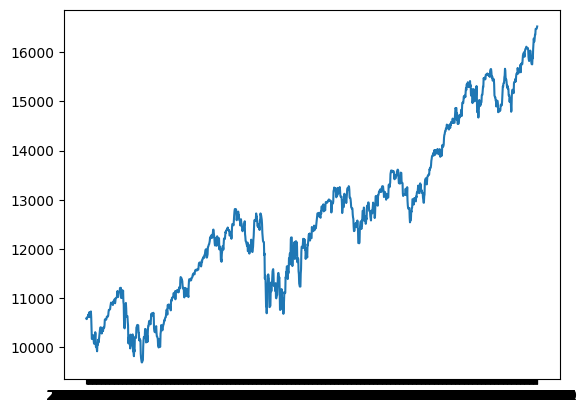

In [58]:
plt.plot(special_data)

## Начало расчёта

### Создаём наш объект для хранения результатов

In [59]:
forecasts = pd.DataFrame(columns = \
                         ['begin_date', 
                          'end_date', 
                          'window_size', 
                          'forecast_days', 
                          'forecast_precision'])

### Задаём все параметры симуляции и моделей

In [60]:
# Размер окна и размер прогноза
window_size = 200
forecast_days = 90
# гиперпараметры
num_epochs = 400
learning_rate = 0.001
input_size = 1
hidden_size = 64 # need to find correct value; 40 small, 64 norm, 100 a lot
num_layers = 1
num_classes = 1
output_size = 1

### Обучаем модель, прогнозируем и сохраняем результат

In [68]:
import sys

train_size = int(0.8 * window_size)
val_size = forecast_days
test_size = int(0.2 * window_size)
sim_len = len(special_data) - window_size - forecast_days - val_size
prev_percent = 0
# начинаем симуляцию
for i in range(0, sim_len):
    percent = int(100 * (i + 1) / sim_len)

    if percent > prev_percent:
        prev_percent = percent
        sys.stdout.write(f"\rПрогресс: {percent}%")
        sys.stdout.flush()
    
    seq_length = 10

    window = special_data[i:i + window_size + forecast_days + 1 + seq_length]
    actual_values = special_data['Price'][i + window_size:i + window_size + forecast_days]
    # Переводим наши данные в тензора на наш расчётный девайс
    sc = MinMaxScaler()
    training_data = sc.fit_transform(window)

    x, y = sliding_windows(training_data, seq_length)


    dataX = Variable(torch.Tensor(np.array(x)).to(device))
    dataY = Variable(torch.Tensor(np.array(y)).to(device))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

    testX = Variable(torch.Tensor(np.array(x[train_size:train_size + test_size])).to(device))
    testY = Variable(torch.Tensor(np.array(y[train_size:train_size + test_size])).to(device))

    valX = Variable(torch.Tensor(np.array(x[train_size + test_size:train_size + test_size + val_size])).to(device))
    valY = Variable(torch.Tensor(np.array(y[train_size + test_size:train_size + test_size + val_size])).to(device))  
    
    #  Создаём классы для наших датасетов
    train_dataset = TimeSeriesDataset(trainX, trainY)
    test_dataset = TimeSeriesDataset(testX, testY)
    val_dataset = TimeSeriesDataset(valX, valY)

    train_loader = DataLoader(train_dataset, batch_size = 10, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = 10, shuffle = False)
    val_loader = DataLoader(val_dataset, batch_size = 10, shuffle = False)

    # Создаём модель 
    model = RNNForecast(input_size, hidden_size, num_layers, output_size).to(device)
    
    # Define loss and optimizer
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

    train_loss = []
    valid_loss = []
    for epoch in range(num_epochs):
        # set the model to train mode
        model.train()

        # forward pass
        output = model(trainX)
        loss = criterion(output, trainY)

        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate training loss
        train_loss.append(loss.item())

        # set the model to evaluation mode
        model.eval()

        # calculate validation loss
        with torch.no_grad():
            output = model(testX)
            loss = criterion(output, testY)
            valid_loss.append(loss.item())

    predY_val = model(valX)
    predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy()).ravel()
    percentage_error = ((predY_val_inv - actual_values) / actual_values) * 100
    result = {
                'begin_date': window.index[0],
                'end_date': window.index[-(forecast_days + val_size + 1)],
                'window_size': window_size,
                'forecast_days': forecast_days,
                'forecast_precision': np.mean(np.abs(percentage_error))
            }
    forecasts = pd.concat([forecasts, pd.DataFrame([result])], ignore_index = True)


KeyboardInterrupt: 

In [62]:
# Преобразуйте столбец 'forecast_precision' к типу данных float
forecasts['forecast_precision'] = pd.to_numeric(forecasts['forecast_precision'], errors='coerce')

# Получите 10 строк с наименьшими значениями в столбце 'forecast_precision'
top_10_rows = forecasts.nsmallest(10, 'forecast_precision', 'all')

In [63]:
top_10_rows

,begin_date,end_date,window_size,forecast_days,forecast_precision
113,2010-04-27,2010-08-25,200,90,0.631251
116,2010-04-30,2010-08-28,200,90,0.640231
112,2010-04-26,2010-08-24,200,90,0.645758
111,2010-04-25,2010-08-23,200,90,0.661544
117,2010-05-01,2010-08-29,200,90,0.670520
114,2010-04-28,2010-08-26,200,90,0.677132
119,2010-05-03,2010-08-31,200,90,0.687023
132,2010-05-16,2010-09-13,200,90,0.692138
120,2010-05-04,2010-09-01,200,90,0.707087
131,2010-05-15,2010-09-12,200,90,0.708627


In [64]:
# Сортировка по forecast_precision и получение первых 10 строк
sorted_result = forecasts.sort_values(by='forecast_precision').head(10)

# Вывод результата
print(sorted_result)

     begin_date    end_date window_size forecast_days  forecast_precision
113  2010-04-27  2010-08-25         200            90            0.631251
116  2010-04-30  2010-08-28         200            90            0.640231
112  2010-04-26  2010-08-24         200            90            0.645758
111  2010-04-25  2010-08-23         200            90            0.661544
117  2010-05-01  2010-08-29         200            90            0.670520
114  2010-04-28  2010-08-26         200            90            0.677132
119  2010-05-03  2010-08-31         200            90            0.687023
132  2010-05-16  2010-09-13         200            90            0.692138
120  2010-05-04  2010-09-01         200            90            0.707087
131  2010-05-15  2010-09-12         200            90            0.708627


In [65]:
result_df = forecasts.groupby(['forecast_days'])['forecast_precision'].mean().reset_index()

In [66]:
print(result_df)

   forecast_days  forecast_precision
0             90            1.455146


In [67]:
forecasts.to_csv('rnn_dje.csv')